In [1]:
!pip install --upgrade requests branca six jinja2 numpy chardet idna urllib3 certifi MarkupSafe
!conda install -c conda-forge folium --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge wordcloud==1.4.1 --yes
import numpy as np
import pandas as pd
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
from wordcloud import WordCloud, get_single_color_func
print('Libraries imported.')

     |████████████████████████████████| 61kB 15.1MB/s eta 0:00:01
Requirement already up-to-date: six in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.12.0)
     |████████████████████████████████| 133kB 23.5MB/s eta 0:00:01
     |████████████████████████████████| 20.4MB 29.2MB/s eta 0:00:01
Requirement already up-to-date: chardet in /opt/conda/envs/Python36/lib/python3.6/site-packages (3.0.4)
Requirement already up-to-date: idna in /opt/conda/envs/Python36/lib/python3.6/site-packages (2.8)
     |████████████████████████████████| 153kB 46.5MB/s eta 0:00:01
Requirement already up-to-date: certifi in /opt/conda/envs/Python36/lib/python3.6/site-packages (2019.6.16)
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: ibm-cos-sdk-core 2.4.3 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.3 which is incompatible.
ERROR: botocore 1.12.82 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.3 which is incompatibl

In [2]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')
print('Loading data...')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


In [3]:
neighborhoods_ny = pd.DataFrame(columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

#Take only neighborhoods from manhattan!
neighborhoods_ny = neighborhoods_ny[neighborhoods_ny['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [4]:
print("{} neighborhoods found in New York city.".format(neighborhoods_ny.shape[0]))

40 neighborhoods found in New York city.


In [5]:
webPage = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
print('Data downloaded!')
print('Loading data...')
html = webPage.text                                                                       
tableInit = html.find('<table class="wikitable sortable">')                            
tableFinal = html.find('</table>')                                                      
htmlTable = html[tableInit:tableFinal]
print('\n...data loaded succesfully!')

Data downloaded!
Loading data...

...data loaded succesfully!


In [6]:
table = pd.read_html(htmlTable, header = 0)[0]                                            
table["Borough"] = table["Borough"].replace({"Not assigned":np.nan})                
table.dropna(inplace = True)                                                          
table.where(table != "Not assigned", table["Borough"], axis = 0, inplace = True)      
joinedRows = table.groupby("Postcode")["Neighbourhood"].apply(lambda x: ", ".join(x)) 
table.drop_duplicates(["Postcode"],inplace = True)                                    
df = table.join(joinedRows, on = "Postcode", lsuffix='_single')                       
df.drop(columns = ["Neighbourhood_single"], inplace = True)                         
df.reset_index(drop = True, inplace = True)

In [7]:
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
neighborhoods_to = df.join(geo, on = "Postcode")

#Take only those neighborhoods that contain the word Toronto
neighborhoods_to = neighborhoods_to[neighborhoods_to['Borough'].str.contains('Toronto')].reset_index(drop=True)
neighborhoods_to.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [8]:
print("\n{} neighborhoods found in the city of Toronto.".format(neighborhoods_to.shape[0]))


38 neighborhoods found in the city of Toronto.


In [9]:
#Visualize the neighborhoods in New York and Toronto

address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City (Manhattan) are {}, {}.'.format(ny_latitude, ny_longitude))

address = 'Toronto'

location = geolocator.geocode(address)
to_latitude = location.latitude
to_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

centerLatitude = (ny_latitude + to_latitude)/2
centerLongitude = (ny_longitude + to_longitude)/2

print('\nThe geograpical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City (Manhattan) are 40.7900869, -73.9598295.
The geograpical coordinate of Toronto are 43.653963, -79.387207.

The geograpical central coordinates are 42.22202495, -76.67351825.


In [10]:
# add NY and TO tables
tmp = neighborhoods_to.drop("Postcode",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
df = neighborhoods_ny.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
...,...,...,...,...
75,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
76,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
77,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


In [11]:

map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

In [12]:
#NY


map_tony = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

In [13]:
#TO


map_tony = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

In [14]:
#Import data from FourSquare

CLIENT_ID = 'ATMWJVPJOHO01CUTDYGM4KYKDOFRVAPRBHKZU31IY023FZGL' # your Foursquare ID
CLIENT_SECRET = 'PVN4NDGE0GNXMFCL001Z5D4VLEV4EIX3T0FWZ4CDDKYAWWUY' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ATMWJVPJOHO01CUTDYGM4KYKDOFRVAPRBHKZU31IY023FZGL
CLIENT_SECRET:PVN4NDGE0GNXMFCL001Z5D4VLEV4EIX3T0FWZ4CDDKYAWWUY


In [15]:
#send GET request

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)

In [16]:
tony_venues = getNearbyVenues(names=df['Neighborhood'],
                                   boroughs = df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

1 | Marble Hill
2 | Chinatown
3 | Washington Heights
4 | Inwood
5 | Hamilton Heights
6 | Manhattanville
7 | Central Harlem
8 | East Harlem
9 | Upper East Side
10 | Yorkville
11 | Lenox Hill
12 | Roosevelt Island
13 | Upper West Side
14 | Lincoln Square
15 | Clinton
16 | Midtown
17 | Murray Hill
18 | Chelsea
19 | Greenwich Village
20 | East Village
21 | Lower East Side
22 | Tribeca
23 | Little Italy
24 | Soho
25 | West Village
26 | Manhattan Valley
27 | Morningside Heights
28 | Gramercy
29 | Battery Park City
30 | Financial District
31 | Carnegie Hill
32 | Noho
33 | Civic Center
34 | Midtown South
35 | Sutton Place
36 | Turtle Bay
37 | Tudor City
38 | Stuyvesant Town
39 | Flatiron
40 | Hudson Yards
41 | Harbourfront, Regent Park
42 | Ryerson, Garden District
43 | St. James Town
44 | The Beaches
45 | Berczy Park
46 | Central Bay Street
47 | Christie
48 | Adelaide, King, Richmond
49 | Dovercourt Village, Dufferin
50 | Harbourfront East, Toronto Islands, Union Station
51 | Little Portugal,

In [17]:
#One hot encoding and grouping by neighborhoods


# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",Downtown Toronto,43.650571,-79.384568,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.010000,0.000000,0.0,0.010000,0.0
1,Battery Park City,Manhattan,40.711932,-74.016869,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.010000,0.030000,0.0,0.030000,0.0
2,Berczy Park,Downtown Toronto,43.644771,-79.373306,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Washington Heights,Manhattan,40.851903,-73.936900,0.011765,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.011765,0.023529,0.0,0.011765,0.0
76,West Village,Manhattan,40.734434,-74.006180,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.040000,0.010000,0.0,0.000000,0.0
77,Yorkville,Manhattan,40.775930,-73.947118,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.01,0.02,0.0,0.0,0.0,0.010000,0.030000,0.0,0.000000,0.0


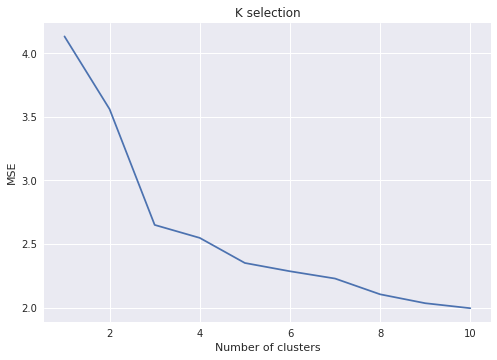

In [18]:
#Clustering

# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [19]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,Manhattan,Marble Hill,40.876551,-73.910660,3
1,Manhattan,Chinatown,40.715618,-73.994279,2
2,Manhattan,Washington Heights,40.851903,-73.936900,3
...,...,...,...,...,...
75,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,2
76,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2
77,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,2


In [20]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [21]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [22]:
# create map
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


minimap = MiniMap(position = 'topleft', center_fixed = (ny_latitude, ny_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (to_latitude, to_longitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [23]:
# 1st cluster

cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

,Neighborhood
49,"Harbourfront East, Toronto Islands, Union Station"
56,Studio District


In [24]:
# 2nd cluster

cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

,Neighborhood
57,Lawrence Park


In [25]:
# 3rd cluster

pd.set_option('max_rows', 100)
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

,Neighborhood
1,Chinatown
4,Hamilton Heights
5,Manhattanville
7,East Harlem
9,Yorkville
10,Lenox Hill
11,Roosevelt Island
15,Midtown
16,Murray Hill
19,East Village


In [26]:
#4th cluster

cl4 = tony_merged.loc[tony_merged['Cluster Labels'] == 3, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl4

,Neighborhood
0,Marble Hill
2,Washington Heights
3,Inwood
6,Central Harlem
8,Upper East Side
12,Upper West Side
13,Lincoln Square
14,Clinton
17,Chelsea
18,Greenwich Village


In [27]:
# 5th cluster

cl5 = tony_merged.loc[tony_merged['Cluster Labels'] == 4, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl5

,Neighborhood
28,Battery Park City
38,Flatiron


Total number of tiles is 400
Cluster I: 10
Cluster II: 10
Cluster III: 138
Cluster IV: 5
Cluster V: 236


<Figure size 576x396 with 0 Axes>

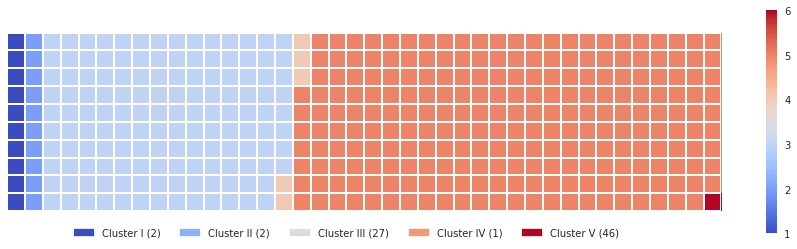

In [28]:
# Waffle chart

def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (categories[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]
    #print(values_cumsum)

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        #color_val = colormap((float(values_cumsum[i])/total_values))
        color_val = colormap(np.linspace(0,1,5)[i])
        #print(np.arange(1,6)[i]/5)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )
    
    

    
index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V']
portions = [cl5.shape[0], cl1.shape[0], cl4.shape[0], cl2.shape[0], cl3.shape[0]]
width = 40 # width of chart
height = 10 # height of chart

categories = index # categories
values = portions # correponding values of categories

colormap = plt.cm.coolwarm# color map class
create_waffle_chart(categories, values, height, width, colormap)

Word cloud created!


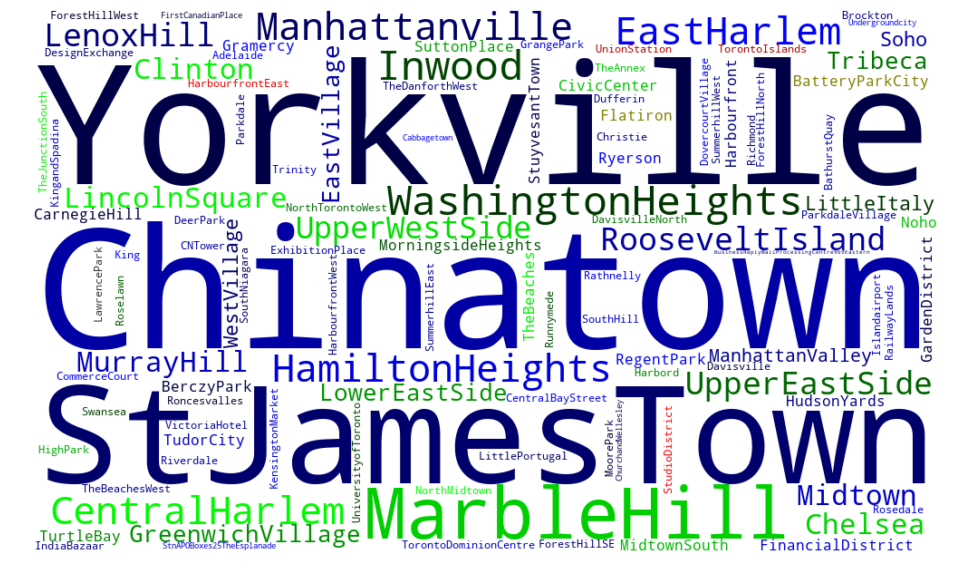

In [30]:
# Word Cloud

word_string = ""
for neighborhood in tony_merged["Neighborhood"]:
    elements = ""
    for element in neighborhood.split(","):
        elements += element.strip().replace(" ", "") + " "
    word_string += elements+" "
word_string = word_string.replace(".","")

tmp = cl1["Neighborhood"].tolist()
cl1_list = []
for element in tmp:
    cl1_list.extend(element.split(", "))
cl1_list = [element.replace(" ","") for element in cl1_list]

tmp = cl2["Neighborhood"].tolist()
cl2_list = []
for element in tmp:
    cl2_list.extend(element.split(", "))
cl2_list = [element.replace(" ","") for element in cl2_list]
    
tmp = cl3["Neighborhood"].tolist()
cl3_list = []
for element in tmp:
    cl3_list.extend(element.split(", "))
cl3_list = [element.replace(" ","") for element in cl3_list]
cl3_list = [element.replace(".","") for element in cl3_list]

tmp = cl4["Neighborhood"].tolist()
cl4_list = []
for element in tmp:
    cl4_list.extend(element.split(", "))
cl4_list = [element.replace(" ","") for element in cl4_list]    

tmp = cl5["Neighborhood"].tolist()
cl5_list = []
for element in tmp:
    cl5_list.extend(element.split(", "))
cl5_list = [element.replace(" ","") for element in cl5_list]

cl1_list




class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words = 500).generate(word_string)

color_to_words = {
    # words below will be colored with a green single color function
    '#FF0000': cl1_list,
    # will be colored with a red single color function
    'black': cl2_list,
    'blue': cl3_list,
    '#00ff00': cl4_list,
    'yellow': cl5_list
}

default_color = 'grey'

print('Word cloud created!')

fig = plt.figure()
fig.set_figwidth(500)
fig.set_figheight(10)

grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wordcloud.recolor(color_func=grouped_color_func)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [31]:
#Bar chart for clusters insights

tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[4,:]
tmp[1,:] = kmeans.cluster_centers_[0,:]
tmp[2,:] = kmeans.cluster_centers_[3,:]
tmp[3,:] = kmeans.cluster_centers_[1,:]
tmp[4,:] = kmeans.cluster_centers_[2,:]
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

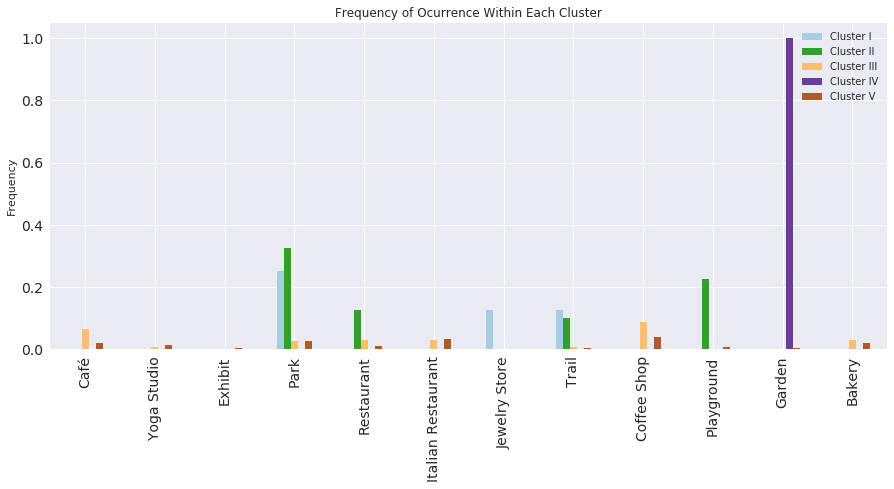

In [32]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [33]:
maxi = []
for i in range(5):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III', 'Cluster IV','Cluster V'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.T
table.drop(["Garden"], inplace= True)

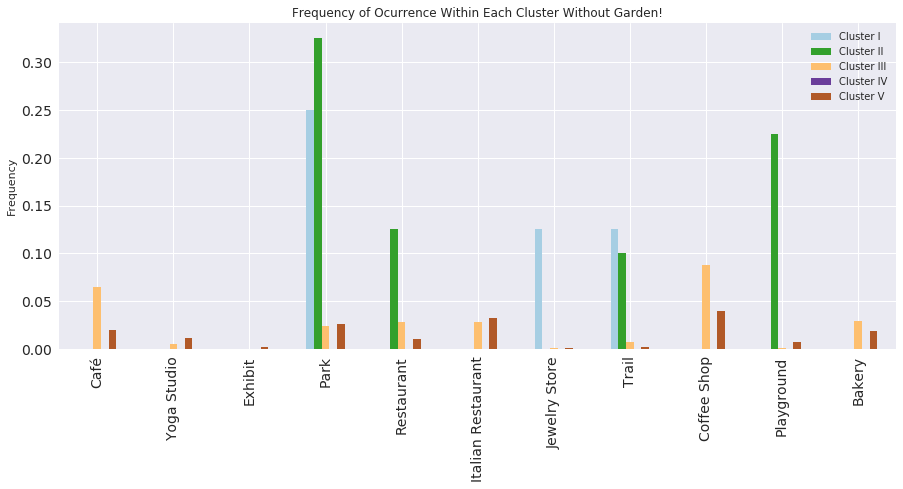

In [34]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = "Paired")
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster Without Garden!")
plt.ylabel("Frequency")
plt.show()